# Pneumonia detector training

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [2]:
!lscpu | grep 'Model name'
!lscpu | grep 'Core(s) per socket'

Model name:                      11th Gen Intel(R) Core(TM) i5-11300H @ 3.10GHz
Core(s) per socket:              4


## Dataset loading

In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [4]:
train = get_training_data('chest_xray/chest_xray/train')
test = get_training_data('chest_xray/chest_xray/test')
val = get_training_data('chest_xray/chest_xray/val')

OpenCV(4.5.2) ../modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.2) ../modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



<ipython-input-3-b2613b36a4a4>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


OpenCV(4.5.2) ../modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.5.2) ../modules/imgproc/src/resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



## Data visualization

/home/red/miniconda3/envs/new/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

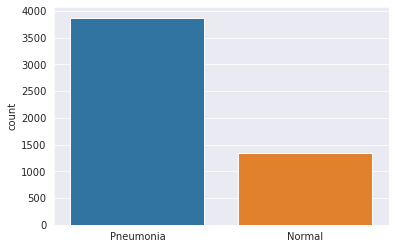

In [5]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)  

Text(0.5, 1.0, 'NORMAL')

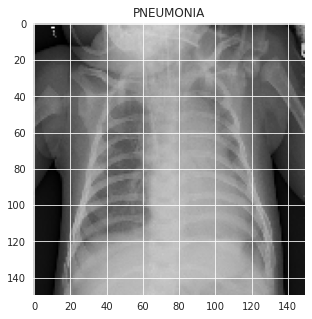

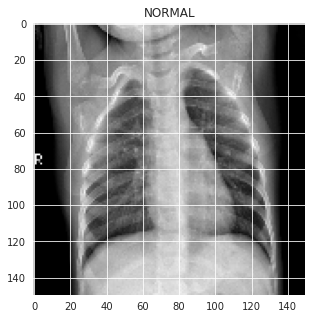

In [6]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

## Preprocessing

In [7]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [8]:
# normalize and resize data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [9]:
print('training shape', x_train.shape)
print('testing shape', x_test.shape)
print('validation shape', x_val.shape)

training shape (5216, 150, 150, 1)
testing shape (624, 150, 150, 1)
validation shape (16, 150, 150, 1)


In [10]:
x, y = np.concatenate([x_train, x_test, x_val], axis=0), np.concatenate([y_train, y_test, y_val])
x_train, x_test_valid, y_train, y_test_valid = train_test_split(
    x, y, shuffle=True, random_state=42, test_size=0.20)
x_test, x_val, y_test, y_val = train_test_split(
    x_test_valid, y_test_valid, shuffle=True, random_state=42, test_size=0.5)

In [11]:
print('After shuffle:')
print('training shape', x_train.shape)
print('testing shape', x_test.shape)
print('validation shape', x_val.shape)

After shuffle:
training shape (4684, 150, 150, 1)
testing shape (586, 150, 150, 1)
validation shape (586, 150, 150, 1)


# Data augmentation

In [12]:
data_generator = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range = 30, # random rotation
        zoom_range = 0.2, # 20% random zoom
        width_shift_range=0.1,  # 10% shift for width and
        height_shift_range=0.1, # height
        horizontal_flip = True, # horizontal flip
        vertical_flip=False)

data_generator.fit(x_train)

# CNN training

In [13]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 38, 38, 64)        0

In [14]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy', patience = 2,
    verbose=1,factor=0.3, min_lr=0.000001
)

In [15]:
history = model.fit(
    data_generator.flow(x_train,y_train, batch_size=32),
    epochs = 16,
    validation_data = data_generator.flow(x_val, y_val),
    callbacks = [learning_rate_reduction]
)

Epoch 1/16
147/147 [==============================] - 68s 458ms/step - loss: 0.9170 - accuracy: 0.7887 - val_loss: 13.1131 - val_accuracy: 0.7321
Epoch 2/16
147/147 [==============================] - 67s 458ms/step - loss: 0.3025 - accuracy: 0.8789 - val_loss: 19.5601 - val_accuracy: 0.7321
Epoch 3/16
147/147 [==============================] - 67s 459ms/step - loss: 0.2794 - accuracy: 0.8949 - val_loss: 26.1232 - val_accuracy: 0.7321

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/16
147/147 [==============================] - 67s 459ms/step - loss: 0.2006 - accuracy: 0.9262 - val_loss: 5.3208 - val_accuracy: 0.7372
Epoch 5/16
147/147 [==============================] - 68s 459ms/step - loss: 0.1996 - accuracy: 0.9422 - val_loss: 0.2799 - val_accuracy: 0.8908
Epoch 6/16
147/147 [==============================] - 67s 459ms/step - loss: 0.1517 - accuracy: 0.9452 - val_loss: 0.9139 - val_accuracy: 0.6468
Epoch 7/16
147/147 [==========================

# Training analysis

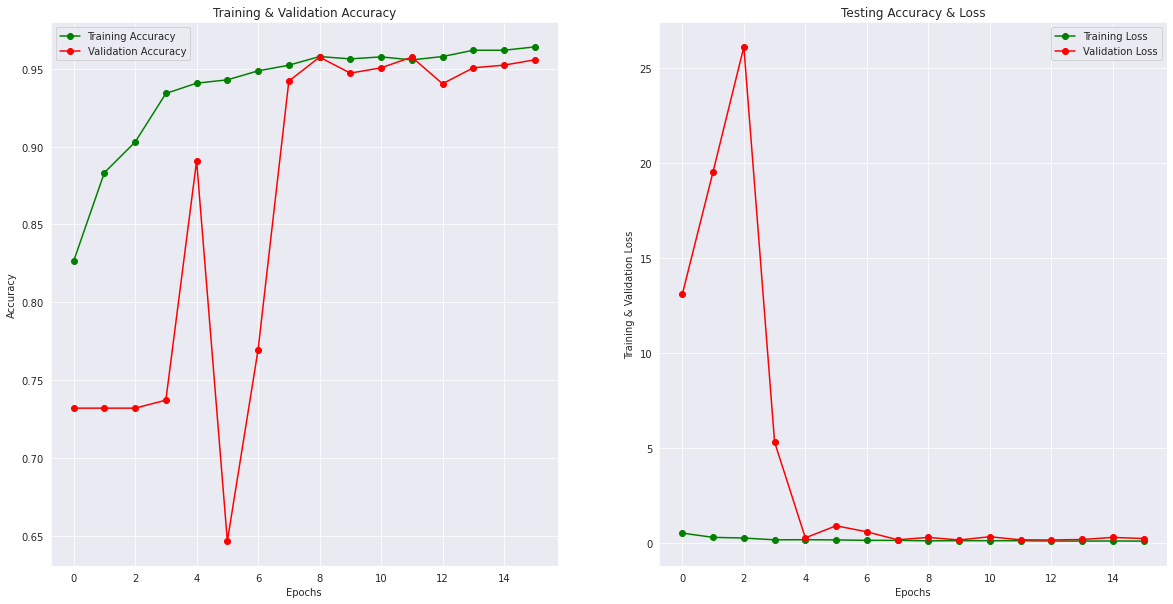

In [16]:
epochs = [i for i in range(16)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

/home/red/miniconda3/envs/new/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


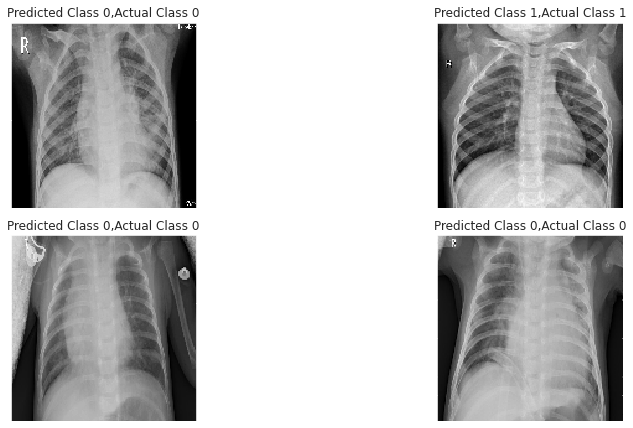

In [18]:
predictions = model.predict_classes(x_test)
predictions = predictions.reshape(1,-1)[0]

correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

plt.rcParams['figure.figsize'] = [12, 9]

i = 0
for c in correct[:4]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

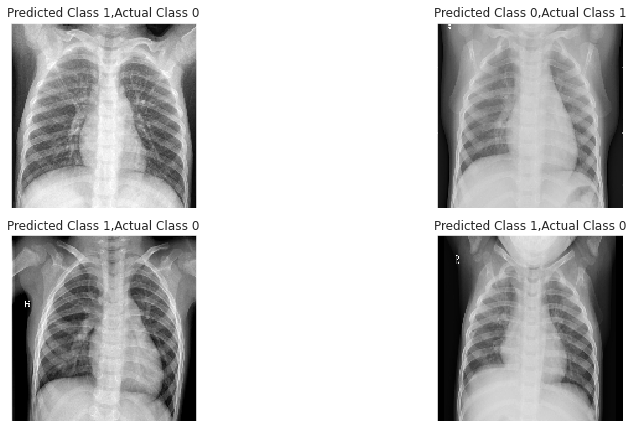

In [19]:
i = 0
for c in incorrect[:4]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

In [20]:
from sklearn.metrics import recall_score, precision_score, accuracy_score

print('Accuracy:', accuracy_score(y_test, predictions))
print('Recall:', recall_score(y_test, predictions))
print('Precision:', precision_score(y_test, predictions))

Accuracy: 0.9112627986348123
Recall: 0.9666666666666667
Precision: 0.7552083333333334


In [21]:
model.save('second_model.keras')